In [2]:
import scipy
import scipy.io.wavfile
import numpy as np
import scipy.stats as stats
from scipy import signal
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd

### Helper functions

##### Miscellaneous

In [3]:
def gen_test_wave(fs,f,amp,t,kind):
  N = int(t * fs)
  n = np.arange(0,N/fs,1/fs)
  if kind=='sin':
    x = np.sin(2 * np.pi * f * n) * amp
  elif kind == 'cos':
    x = np.cos(2 * np.pi * f * n) * amp
  elif kind == 'delta':
    x = np.zeros(N)
    x[0] = 1
  return x

In [4]:
def read_to_linear(path,bd,lin=0):
  fs,x = scipy.io.wavfile.read(path)
  if lin:
    return fs,x
  if bd == 16:
    x = x.astype(np.float32, order='C') / 32768.0  
  elif bd == 32:
    x = x.astype(np.float32, order='C') / 2147354889.0 
  return fs,x 

##### Plot functions

In [5]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int32(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter
    
# class Multiple:
#     def __init__(self, denominator=2, number=np.pi, latex='\pi'):
#         self.denominator = denominator
#         self.number = number
#         self.latex = latex

#     def locator(self):
#         return plt.MultipleLocator(self.number / self.denominator)
        
#     def formatter(self):
#         return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [6]:
def plot_fft(audio,fs,title='output spectrum'):
  N = len(audio)
  w = scipy.signal.windows.hann((N))
  w_fft = scipy.fft.fft(w*audio)
  xf = scipy.fft.fftfreq(N, 1/fs)[:N//2]
  plt.plot(xf, 2.0/N * np.abs(w_fft[0:N//2]),label='fft hann window')
  plt.title(title)
  plt.legend()
  plt.show()

In [7]:
def freqz(x,fs):
    w,h = scipy.signal.freqz(x,1,4096)
    H = 20 * np.log10(np.abs(h))
    f = w / (2 * np.pi) * fs
    angles = np.unwrap(np.angle((h)))
    return f,H,angles

def plot_magnitude_response(f,H,label='magnitude',c='b',title=''):
    ax = plt.subplot(111)
    # magnitude response
    plt.plot(f,H,label=label,color=c)
    ax.semilogx(f, H)
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency [hz]')
    plt.title(title + "Magnitude response")

def plot_phase_response(f,angles,mult_locater=(np.pi/2),denom=2,label='phase',c='b',title=''):
    ax = plt.subplot(111)
    plt.plot(f,angles,label=label,color=c)
    ax.semilogx(f, angles)
    plt.ylabel('Angle [radians]')
    plt.xlabel('Frequency [hz]')
    plt.title(title + "Phase response")
    ax.yaxis.set_major_locator(plt.MultipleLocator(mult_locater))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=denom)))

In [8]:
def plot_bode(x, fs):
    f,H,angles = freqz(x,fs)
    # Plot the magnitude response of a signal x.
    plot_magnitude_response(f,H)
    plt.show()
    # phase response
    plot_phase_response(f,angles)
    plt.show()

In [9]:
def ltspice_freqz(filename, out_label='V(vout)'):
    def imag_to_mag(z):
        # Returns the maginude of an imaginary number.
        a, b = map(float, z.split(','))
        return 20*np.log10(np.sqrt(a*a + b*b))

    def imag_to_phase(z):
        a,b = map(float,z.split(','))
        return np.arctan2(b,a)

    x = pd.read_csv(filename, delim_whitespace=True)
    x['H_dB'] = x[out_label].apply(imag_to_mag)
    x['Phase'] = x[out_label].apply(imag_to_phase)
    f = np.array(x['Freq.'])
    H_db = np.array(x['H_dB'])
    angles = np.array(x['Phase'])
    return f,H_db,angles

In [10]:
def plot_ltspice_bode(filename,mult_locater=(np.pi/2),denom=2):

    f,H_db,angles = ltspice_freqz(filename)
    plot_magnitude_response(f,H_db)
    plt.show()

    plot_phase_response(f,angles,mult_locater=mult_locater,denom=denom)
    plt.show()

In [11]:
def compare_vs_spice(x,fs,spicepath,mult_locater=(np.pi/2),denom=2,title=''):
    wdf_f, wdf_H, wdf_angles = freqz(x,fs)
    spice_f,spice_H,spice_angles = ltspice_freqz(spicepath)
    plot_magnitude_response(wdf_f,wdf_H,label='wdf')
    plot_magnitude_response(spice_f,spice_H,label='spice',c='orange',title=title)
    plt.legend()
    plt.show()

    plot_phase_response(wdf_f,wdf_angles,label='wdf')
    plot_phase_response(spice_f,spice_angles,label='spice',mult_locater=mult_locater,denom=denom,c='orange',title=title)
    plt.legend()
    plt.show()

### Base one port object

In [12]:
class WDFOnePort():
    def __init__(self):
        # Incident- and reflected wave variables.
        self.a, self.b = 0, 0
        self.parent = None

    def connect_to_parent(self,p):
      self.parent = p

    def propagate_impedance_change(self):
      self.calc_impedance()
      if self.parent != None:
        self.parent.propagate_impedance_change()
              
    def wave_to_voltage(self):
        voltage = (self.a + self.b) / 2
        return voltage

    def wave_to_current(self):
        current = (1 / 2 * self.Rp) * (self.a + self.b)
        return current

    def __str__(self):
      return 'wdf one port'

    def __repr__(self):
      return self.__str__()

    def calc_impedance(self):
      pass

    def set_incident_wave(self,a):
      pass

    def get_reflected_wave(self):
      pass

class rootWDF(WDFOnePort):
  def __init__(self):
    WDFOnePort.__init__(self)
    self.next = None

  def connectToParent(self,p):
    pass  

  def propogateImpedanceChange(self):
    self.calcImpedance()

### Resistor

In [13]:
class Resistor(WDFOnePort):
    def __init__(self, R):
      WDFOnePort.__init__(self)
      self.Rval = R  # Port resistence set to physical resistance
      self.calc_impedance()

    def calc_impedance(self):
      self.Rp = self.Rval

    def set_resistance(self,R):
      if self.Rval == R:
        return
      self.Rval = R
      self.propagate_impedance_change()
    
    def __str__(self):
      return str(self.Rp) + " Ohm Resistor"
    
    def set_incident_wave(self,a):
      self.a = a

    def get_reflected_wave(self):
      self.b = 0
      return self.b

### Capacitor & inductor

In [14]:
class Capacitor(WDFOnePort):
    def __init__(self, C, fs, tolerance=0,sSize=10):
      WDFOnePort.__init__(self)
      # gaussian distribution of vals below and above given C according to tolerance 
      # random sample is selected and added to given capacitance value
      self.tol = tolerance
      self.data_normal = stats.norm.rvs(size = sSize,loc = 0, scale = C * self.tol / 2)
      rand_samp = np.random.choice(self.data_normal)
      self.C = C + rand_samp     
      self.fs = fs
      self.z = 0 
      self.calc_impedance()

    def set_capacitance(self,C):
      if self.C == C:
        return
      self.C = C
      self.propagate_impedance_change()
    
    def calc_impedance(self):
      self.Rp = 1 / (2 * self.fs * self.C)
    
    def reset(self):
      self.z = 0

    def __str__(self):
      return str(self.C) + " farad Capacitor"

    def get_reflected_wave(self):
        self.b = self.z
        return self.b
    
    def set_incident_wave(self, a):
        self.a = a
        self.z = self.a

class Inductor(WDFOnePort):
    def __init__(self, L,fs):
      WDFOnePort.__init__(self)
      self.fs = fs
      self.L = L
      self.z = 0
      self.calc_impedance()

    def calc_impedance(self):
      self.Rp = 2 * self.fs * self.L

    def set_inductance(self,L):
      self.L = L
      self.propagate_impedance_change()

    def __str__(self):
      return str(self.L) + " henry Inductor"
    
    def get_reflected_wave(self):
      self.b = -self.z
      return self.b
    
    def set_incident_wave(self, a):
      self.a = a
      self.z = self.a

### Short circuit, open circuit & switch

In [15]:
class ShortCircuit(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
    
    def get_reflected_wave(self, a):
        self.a = a
        self.b = -a
        return self.b

class OpenCircuit(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
    
    def get_reflected_wave(self):
        self.b = self.a
        return self.b

class Switch(WDFOnePort):
    def __init__(self):
        WDFOnePort.__init__(self)
        __state = False 
    
    def get_reflected_wave(self):
        if __state: # Switch closed
            self.b = -self.a
        else:       # Switch open
            self.a = self.a
            self.b = self.a
            
        return self.b
    
    def change_state(self, state):
        __state = state

### Ideal voltage & current sources

In [16]:
class IdealVoltageSource(rootWDF):
    def __init__(self,next):
        rootWDF.__init__(self)
        self.next = next
        self.next.connect_to_parent(self)
        self.Vs = 0
        self.Rp = 0

    def __str__(self):
      return "Ideal voltage source"
        
    def set_voltage(self,vs):
      self.Vs = vs

    def set_incident_wave(self,a):
      self.a = a

    def get_reflected_wave(self):
      self.b = 0 - self.a + 2 * self.Vs
      return self.b

class IdealCurrentSource(rootWDF):
    def __init__(self):
        rootWDF.__init__(self)
        
    def __str__(self):
      return "Ideal current source"

    def get_reflected_wave(self, i_s=0):
        self.b = self.a - 2*R_p*i_s
        return self.b

### Resistive voltage & current sources

In [17]:
class ResistiveVoltageSource(WDFOnePort):
    def __init__(self, Rs):
      WDFOnePort.__init__(self)
      self.Rval = Rs
      self.v_s = 0
      self.calc_impedance()
  
    def calc_impedance(self):
      self.Rp = self.Rval
    
    def __str__(self):
      return str(self.Rp) + " Ohm resistive voltage source"

    def set_voltage(self,v_s):
      self.v_s = v_s

    def set_incident_wave(self,a):
      self.a = a

    def get_reflected_wave(self):
      self.b = self.v_s
      return self.b

class ResistiveCurrentSource(WDFOnePort):
    def __init__(self, R):
      WDFOnePort.__init__(self)
      self.Rval = R

    def calc_impedance(self):
      self.Rp = self.Rval
    
    def __str__(self):
      return str(self.Rp) + " Ohm resistive current source"

    def get_reflected_wave(self,i_s=0):
        self.b = self.Rp*i_s
        return self.b

### Omega function approximation

In [18]:
def omega4(x):
    x1 =  -3.341459552768620
    x2 = 8.0
    a =  -1.314293149877800e-3
    b = 4.775931364975583e-2
    c = 3.631952663804445e-1
    d = 6.313183464296682e-1
    if x < x1:
        y = 0
    elif x < x2:
        y = d + x * (c + x * (b + x * a))
    else:
        y = x - np.log(x)
    return y - (y - np.exp(x - y) / (y + 1))

### Diode 

In [19]:
class Diode_pair(rootWDF):
    def __init__(self,next,nDiodes=2,Is=2.52e-9,Vt = 25.85e-3,q="best"):
      WDFOnePort.__init__(self)
      self.q = q
      self.next = next
      self.next.connect_to_parent(self)
      self.set_params(Is,Vt,nDiodes)
      self.calc_impedance()

    def set_params(self,Is,Vt,nDiodes):
      self.Is = Is
      self.Rp = self.next.Rp
      self.Vt = Vt * nDiodes
      self.oneOverVt = 1. / self.Vt

    def calc_impedance(self):
      self.R_Is = self.Rp * self.Is
      self.R_Is_overVT = self.R_Is * self.oneOverVt
      self.logR_Is_overVT = np.log(self.R_Is_overVT)

    def set_incident_wave(self,a):
      self.a = a

    def get_reflected_wave(self):
      lam = np.sign(self.a)
      lam_a_overVT = lam * self.a / self.Vt
      if self.q == "best":
          self.b = self.a - (2 * self.Vt) * lam * (omega4(self.logR_Is_overVT + lam_a_overVT)) - omega4(self.logR_Is_overVT - lam_a_overVT)
      elif self.q == "good":
          self.b = self.a + 2 * lam * (self.R_Is - self.Vt * omega4(self.logR_Is_overVT + lam * self.a * self.oneOverVt + self.R_Is_overVT))
      return self.b

### 3 port adaptors

In [20]:
class adaptor(WDFOnePort):
  def __init__(self,p1,p2):
    WDFOnePort.__init__(self)
    self.p1_reflect = 1.
    self.p1 = p1
    self.p2 = p2
    self.p1.connect_to_parent(self)
    self.p2.connect_to_parent(self)
    self.calc_impedance()

class Series(adaptor):
  def __init__(self,p1,p2):
    adaptor.__init__(self,p1,p2)

  def calc_impedance(self):
    self.Rp = self.p1.Rp + self.p2.Rp
    self.G = 1./self.Rp
    self.p1_reflect = self.p1.Rp / self.Rp

  def set_incident_wave(self,a):
    b1 = self.p1.b - self.p1_reflect * (a + self.p1.b + self.p2.b)
    self.p1.set_incident_wave(b1)
    self.p2.set_incident_wave(0 - (a + b1))
    self.a = a

  def get_reflected_wave(self):
    self.b = 0 - self.p1.get_reflected_wave() + self.p2.get_reflected_wave()
    return self.b

class Parallel(adaptor):
  def __init__(self,p1,p2):
    adaptor.__init__(self,p1,p2)
    self.b_temp = 0
    self.b_diff = 0

  def calc_impedance(self):
    self.G = (1./self.p1.Rp) + (1./self.p2.Rp)
    self.Rp = 1./self.G
    self.p1_reflect = (1./self.p1.Rp) / self.G

  def set_incident_wave(self,a):
    b2 = a + self.b_temp
    self.p1.set_incident_wave(self.b_diff + b2)
    self.p2.set_incident_wave(b2)
    self.a = a

  def get_reflected_wave(self):
    self.p1.get_reflected_wave()
    self.p2.get_reflected_wave()
    self.b_diff = self.p2.b - self.p1.b
    self.b_temp = 0 - self.p1_reflect * self.b_diff
    self.b = self.p2.b + self.b_temp
    return self.b

### Diode clipper

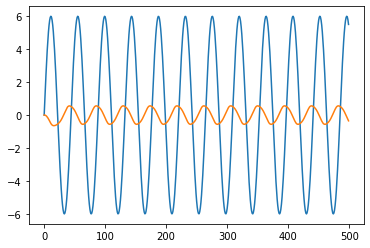

In [28]:
fs = int(44100)
f = 1000
amp = 6
t = .5

x = gen_test_wave(fs,f,amp,t,kind='sin')
output = np.zeros(len(x))

cutoff = 100
c = 47e-9
r = 1 / (2 * np.pi * cutoff * c)

R1 = Resistor(r)
Vs = ResistiveVoltageSource(1e-9)
S1 = Series(Vs,R1)

C1 = Capacitor(47e-9,fs)
P1 = Parallel(S1, C1)

dp = Diode_pair(P1,nDiodes=2)

for i in range(len(x)):
  Vs.set_voltage(x[i])
  dp.set_incident_wave(P1.get_reflected_wave())
  y = C1.wave_to_voltage()
  P1.set_incident_wave(dp.get_reflected_wave())
  output[i] = y

plt.plot(x[:500])
plt.plot(output[:500])
plt.show()
# spice_path = '/Users/gusanthon/Documents/UPF/Thesis/diode-clipper-frequency-analysis.txt'
# compare_vs_spice(output,fs,spice_path,mult_locater=(np.pi/3),denom=3,title='Diode clipper ')

### Passive LPF

5.305164769729845e-08


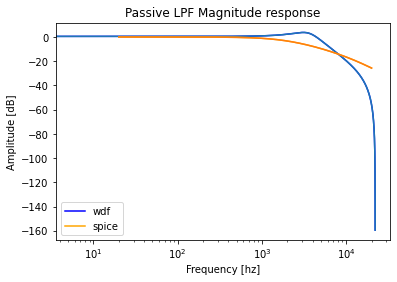

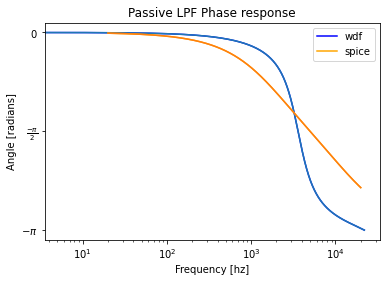

In [22]:
fs = int(44100)
f = 1000
amp = 1
t = .5

x = gen_test_wave(fs,f,amp,t,kind='delta')
output = np.zeros(len(x))

cutoff = 5000
# c = 5e-8
# r = 1 / (2 * np.pi * cutoff * c)
r = 600
c = 1 / (2 * np.pi * cutoff * r)
print(c)
R1 = Resistor(r)
R2 = Resistor(r)

C1 = Capacitor(c,fs)
C2 = Capacitor(c,fs)
# C2.set_capacitance(c*3)
# C1.set_capacitance(c*3)
S1 = Series(R2,C2)
P1 = Parallel(C1,S1)
S2 = Series(R1,P1)

Vs = IdealVoltageSource(P1)

for i in range(len(x)):
  Vs.set_voltage(x[i])
  Vs.set_incident_wave(S2.get_reflected_wave())
  # y = C2.wave_to_voltage()
  S2.set_incident_wave(Vs.get_reflected_wave())
  y = C2.wave_to_voltage()

  output[i] = y

# plot_bode(output,fs)

# plot_ltspice_bode('/Users/gusanthon/Documents/UPF/Thesis/passive_LPF_spice_data.txt')
spice_path = '/Users/gusanthon/Documents/UPF/Thesis/Passive_LPF_Spice.txt'
compare_vs_spice(output,fs,spice_path,title="Passive LPF ")

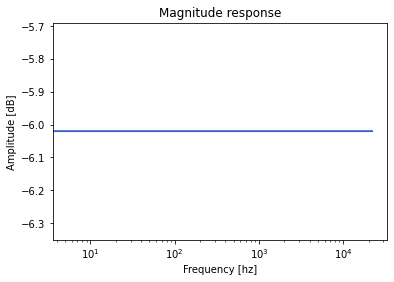

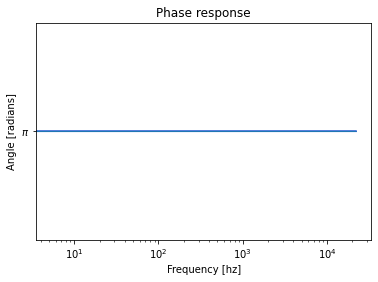

In [23]:
x = gen_test_wave(fs,f,amp,t,kind='delta')
output = np.zeros(len(x))

R1 = Resistor(10000)
Vs = ResistiveVoltageSource(1e-9)
S1 = Series(Vs,R2)

for i in range(len(x)):
  Vs.set_voltage(x[i])
  R1.set_incident_wave(S1.get_reflected_wave())
  y = R1.wave_to_voltage()
  S1.set_incident_wave(Vs.get_reflected_wave())
  output[i] = y

plot_bode(output,fs)

In [24]:
import pyperclip

cutoff = 10000
r = 600
c = 1 / (2 * np.pi * cutoff * r)

spice_cmd = '.step param XC list' 

for i in range(8):
    spice_cmd +=  ' ' + str(c*i/2) 

pyperclip.copy(spice_cmd)
print(spice_cmd)

.step param XC list 0.0 1.3262911924324612e-08 2.6525823848649224e-08 3.978873577297384e-08 5.305164769729845e-08 6.631455962162306e-08 7.957747154594767e-08 9.284038347027228e-08
